In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sqlite3
import json
import statsmodels.api as sm
from lmfit.model import Model, save_modelresult, load_modelresult
from lmfit.models import LinearModel
from lmfit import minimize, Parameters, create_params

In [3]:
def thousands(x, pos):
    'The two args are the value and tick position, helper fn'
    return '%1.2f' % (x * 1e3)

def melt_fit(x, a, b, c, d, f, g):
    # a: slope of the unfolded state
    # b: y-intercept of the unfolded state
    # c: slope of the folded state
    # d: y-intercept of the folded state
    # f: energy of the transition state
    # g: temperature of the transition state
    
    temp = 1 / x

    R = 0.001987
    R = 0.0083145
    K1 = np.exp((f/R)*(1/(g+273.15) - 1/(temp)))
    Q1 = 1 + K1
    fracu = 1 / Q1
    fracf = K1 / Q1
    basef = a * x + b
    baseu = c * x + d

    final = np.log(fracu) * baseu + np.log(fracf) * basef
    final = fracu * baseu + fracf * basef
    return final

def fit_meltcurve(x, y, kadd_params = None):
    # Make sure x is sorted

    # Guess top baseline
    model = LinearModel()
    params = model.guess(y.iloc[:3], x = x.iloc[:3])
    top_fit = model.fit(y.iloc[:3], params, x = x.iloc[:3])
    init_m_top = top_fit.params['slope'].value
    init_b_top = top_fit.params['intercept'].value

    # Guess bottom baseline
    params = model.guess(y.iloc[-3:], x = x.iloc[-3:])
    bot_fit = model.fit(y.iloc[-3:], params, x = x.iloc[-3:])
    init_m_bot = bot_fit.params['slope'].value
    init_b_bot = bot_fit.params['intercept'].value
    
    init_m = (init_m_top + init_m_bot) / 2

    # Actual fit
    melt_model = Model(melt_fit)
    melt_params = melt_model.make_params(a = init_m_bot, b = init_b_bot, c = init_m_top, d = init_b_top, f = -500, g = 40)
    melt_params['g'].vary = True
    # bottom intercept needs to be lower than upper intercept
    melt_params['b'].max = init_b_top

    if kadd_params is not None:
        # lock to kadd_params
        kadd_slope, kadd_intercept = kadd_params
        melt_params['c'].value = kadd_slope
        melt_params['d'].value = kadd_intercept
        melt_params['c'].vary = False
        melt_params['d'].vary = False
    

    # set minimum f -1000
    #melt_params['f'].min = -1000
    # top slope = bot slope
    #melt_params['a'].expr = 'c'
    melt_result = melt_model.fit(y, melt_params, x = x, method = 'least_squares', verbose = True)
    # try:
    #     melt_result = melt_model.fit(y, melt_params, x = x, method = 'least_squares', verbose = True)

    # except ValueError as e:
    #     if "The model function generated NaN values" in str(e):
    #         print("Caught the NaN generation error. Handling it...")
    #         return None
    #         # Handle the error, for example, by logging it, adjusting model parameters, or using default values
            
    #     else:
    #         print('some other error')
    #         # If the error message is different, you might want to raise the error again or handle it differently
    #         return None
    
    # remove outlier outside 1.5sigma
    # outlier = np.abs(melt_result.residual) > 150 * np.std(melt_result.residual)
    # if sum(outlier) > 0:
    #     x_no_outlier = x[~outlier]
    #     y_no_outlier = y[~outlier]
    #     melt_result = melt_model.fit(y_no_outlier, melt_params, x = x_no_outlier, method = 'least_squares')

    return melt_result

# calculate smoothed best-fit values based on melt_result
def calc_smoothed_best_fit(melt_result):
    x = melt_result.userkws['x']
    x_data = np.linspace(min(x), max(x), 1000)
    y_data = melt_result.eval(x = x_data)
    return x_data, y_data

In [4]:
# Load data

global_fits = '/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/global_refit_results.db'

conn = sqlite3.connect(global_fits)
query = 'SELECT * FROM global_fits'
fits = pd.read_sql_query(query, conn)
fits

# get experimental info
main_db  = '/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.060.developing_DB_input/new.db'
conn = sqlite3.connect(main_db)
query = """
    SELECT pr.temperature, c.disp_name, rg.rg_id, pr.buffer_id
    FROM reaction_groups rg
    JOIN constructs c ON pr.construct_id = c.id
    LEFT JOIN probing_reactions pr ON rg.rxn_id = pr.id
    WHERE pr.RT = 'MRT'
    GROUP BY rg.rg_id
"""
exp_info = pd.read_sql_query(query, conn)
fits['rg_id'] = fits['rg_id'].astype(int)
fits = fits.merge(exp_info, left_on='rg_id', right_on='rg_id', how='left')

# drop duplicates
fits = fits.drop_duplicates()
# filter fits to under 85C
fits = fits[fits['temperature'] < 85]
fits

,site,log_kappa,log_kdeg,log_fmod_0,r2,stderr_log_kappa,stderr_log_kdeg,stderr_log_fmod_0,rg_id,temperature,disp_name,buffer_id
0,1,-6.816452,-8.121080,-11.629118,0.953716,0.110213,0.0,9.961597,7,25,4U_a8c,1
1,2,-5.267578,-8.121080,-6.841065,0.917437,0.150436,0.0,0.531036,7,25,4U_a8c,1
2,3,-4.680462,-8.121080,-5.801307,0.938039,0.129168,0.0,0.288928,7,25,4U_a8c,1
3,5,-7.617252,-8.121080,-7.020689,0.684740,0.339345,0.0,0.137336,7,25,4U_a8c,1
4,6,-6.082823,-8.121080,-6.875103,0.920598,0.147028,0.0,0.238243,7,25,4U_a8c,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6801,45,-3.500979,-3.623204,-6.523956,0.990812,0.043757,0.0,0.691059,118,70,hiv_c30u,4
6802,61,-4.128334,-3.623204,-8.138642,0.984694,0.056234,0.0,2.414572,118,70,hiv_c30u,4
6803,62,-4.218293,-3.623204,-8.518886,0.995414,0.030594,0.0,1.758088,118,70,hiv_c30u,4
6804,63,-6.942364,-3.623204,-6.424360,0.822663,0.207726,0.0,0.097666,118,70,hiv_c30u,4


In [5]:
# degradation rate from NMR

temps = []
reps = []
kdeg_vals = []

for temp in [25, 30, 37, 45, 52, 60]:
    for rep in ['a', 'b']:
        if temp == 30 and rep =='b':
            continue
        # read json-like file /home/ekc5108/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.058.XSB_training_DMS/nmr_dms_deg/52_a.sav
        with open(f'/home/ekc5108/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.058.XSB_training_DMS/nmr_dms_deg/{temp}_{rep}.sav') as f:
            data = json.load(f)
        kdeg_val = 1 / data['params'][1][1]
        temps.append(temp)
        reps.append(rep)
        kdeg_vals.append(kdeg_val)

df_kdeg = pd.DataFrame({'temperature': temps, 'replicate': reps, 'kdeg': kdeg_vals})
df_kdeg['log_kdeg'] = np.log(df_kdeg['kdeg'])
df_kdeg['inv_temp'] = 1 / (df_kdeg['temperature'] + 273.15)
df_kdeg['disp_name'] = 'nmr'
df_kdeg = df_kdeg[['log_kdeg', 'temperature', 'disp_name', 'inv_temp']]
# # linear fit to get curve
# model = lmfit.models.LinearModel()
# params = model.make_params()
# deg_result = model.fit(df_kdeg['lnkdeg'], params, x=df_kdeg['inv_temp'])

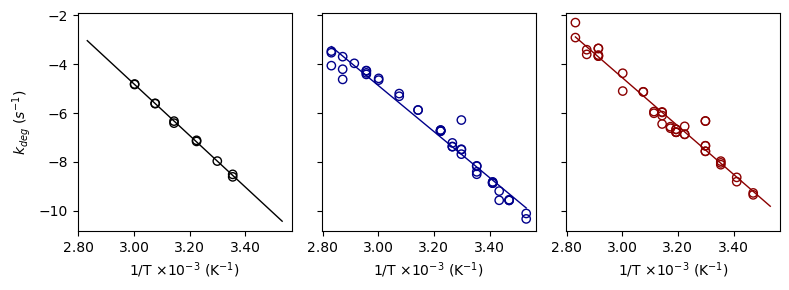

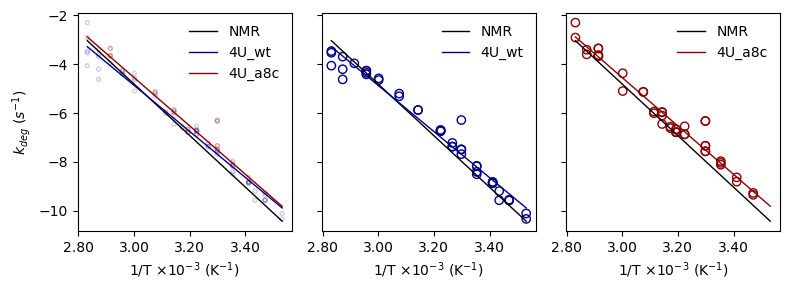

In [6]:
def linear_fit(df_kdeg):
    model = LinearModel()
    params = model.make_params()
    deg_result = model.fit(df_kdeg['log_kdeg'], params, x=df_kdeg['inv_temp'])
    return deg_result

# globally fitted kdeg vals - assessment of global fits
construct = '4U_a8c'
kdeg_curve = fits[fits['disp_name'].isin(['4U_a8c', '4U_wt'])]
kdeg_curve = kdeg_curve[['log_kdeg', 'temperature', 'disp_name']].drop_duplicates()
kdeg_curve['inv_temp'] = 1/(273.15 + kdeg_curve['temperature'])
kdeg_curve = kdeg_curve[kdeg_curve['log_kdeg'] < -1]

kdeg_curve_wt = kdeg_curve[kdeg_curve['disp_name'] == '4U_wt']
kdeg_curve_a8c = kdeg_curve[kdeg_curve['disp_name'] == '4U_a8c']
kdeg_curve_nmr = df_kdeg[df_kdeg['disp_name'] == 'nmr']

wt_result = linear_fit(kdeg_curve_wt)
a8c_result = linear_fit(kdeg_curve_a8c)
nmr_result = linear_fit(kdeg_curve_nmr)


# calc best fit
x_range = np.array([min(kdeg_curve_wt['inv_temp'].min(), kdeg_curve_a8c['inv_temp'].min(), kdeg_curve_nmr['inv_temp'].min()), 
                    max(kdeg_curve_wt['inv_temp'].max(), kdeg_curve_a8c['inv_temp'].max(), kdeg_curve_nmr['inv_temp'].max())])
wt_bestfit = wt_result.eval(x = x_range)
a8c_bestfit = a8c_result.eval(x = x_range)
nmr_bestfit = nmr_result.eval(x = x_range)

concat = pd.concat([df_kdeg, kdeg_curve])
fig, axs = plt.subplots(1, 3, figsize = (8, 3), sharey = True, sharex = True)
axs[0].scatter(x = kdeg_curve_nmr['inv_temp'], y = kdeg_curve_nmr['log_kdeg'], facecolors='none', edgecolors='black')
axs[1].scatter(x = kdeg_curve_wt['inv_temp'], y = kdeg_curve_wt['log_kdeg'], facecolors='none', edgecolors='darkblue')
axs[2].scatter(x = kdeg_curve_a8c['inv_temp'], y = kdeg_curve_a8c['log_kdeg'], facecolors='none', edgecolors='darkred')

axs[0].plot(x_range, nmr_bestfit, color = 'black', linewidth = 1)
axs[1].plot(x_range, wt_bestfit, color = 'darkblue', linewidth = 1)
axs[2].plot(x_range, a8c_bestfit, color = 'darkred', linewidth = 1)


formatter = FuncFormatter(thousands)

axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_ylabel(r'$k_{deg}$ ($s^{-1}$)')
axs[0].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[1].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[2].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 3, figsize = (8, 3), sharey = True, sharex = True)
axs[1].scatter(x = kdeg_curve_wt['inv_temp'], y = kdeg_curve_wt['log_kdeg'], facecolors='none', edgecolors='darkblue')
axs[2].scatter(x = kdeg_curve_a8c['inv_temp'], y = kdeg_curve_a8c['log_kdeg'], facecolors='none', edgecolors='darkred')

axs[0].scatter(x = kdeg_curve_wt['inv_temp'], y = kdeg_curve_wt['log_kdeg'], facecolors='none', edgecolors='darkblue', s = 8, alpha = 0.2)
axs[0].scatter(x = kdeg_curve_a8c['inv_temp'], y = kdeg_curve_a8c['log_kdeg'], facecolors='none', edgecolors='darkred', s = 8, alpha = 0.2)

axs[1].plot(x_range, nmr_bestfit, color = 'black', linewidth = 1, label = 'NMR')
axs[2].plot(x_range, nmr_bestfit, color = 'black', linewidth = 1, label = 'NMR')
axs[1].plot(x_range, wt_bestfit, color = 'darkblue', linewidth = 1, label = '4U_wt')
axs[2].plot(x_range, a8c_bestfit, color = 'darkred', linewidth = 1, label = '4U_a8c')

axs[0].plot(x_range, nmr_bestfit, color = 'black', linewidth = 1, label = 'NMR')
axs[0].plot(x_range, wt_bestfit, color = 'darkblue', linewidth = 1, label = '4U_wt')
axs[0].plot(x_range, a8c_bestfit, color = 'darkred', linewidth = 1, label = '4U_a8c')


formatter = FuncFormatter(thousands)

axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_ylabel(r'$k_{deg}$ ($s^{-1}$)')
axs[0].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[1].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[2].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[0].legend(frameon = False)
axs[1].legend(frameon = False)
axs[2].legend(frameon = False)
plt.tight_layout()
plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/kdeg_global_fits.pdf')
plt.show()

In [7]:
# filter disp_name "4U_wt"
construct = '4U_wt'
# get available sites for given construct (disp_name)
fits[(fits['disp_name'] == construct)]['site'].unique()

array([ 1,  2,  3,  5,  6,  7,  8, 13, 15, 16, 18, 19, 20, 21, 22, 26, 29,
       30, 31, 34, 35, 61, 63, 64,  9, 11, 12, 14, 17, 24, 25, 27, 28, 32,
       33, 62, 36, 10,  4])

In [8]:
def eval_extrapolate(x, slope, slope_err, intercept, intercept_err):
    """
    Evaluate a linear function y = mx + b at a given x with propagated uncertainty.
    
    Parameters:
    x (float): The x-value at which to evaluate the function.
    slope (float): The slope (m) of the linear function.
    slope_err (float): The uncertainty in the slope.
    intercept (float): The intercept (b) of the linear function.
    intercept_err (float): The uncertainty in the intercept.
    
    Returns:
    tuple: (y, uncertainty_y), where y is the evaluated value and uncertainty_y is the propagated uncertainty.
    """
    y = slope * x + intercept
    uncertainty_y = np.sqrt((x * slope_err) ** 2 + intercept_err ** 2)
    
    return y, uncertainty_y

def fit_melting_curve(fits, construct, site, kadd_params = None, agg_mean = False):
    """
    Fit a melting curve for a given construct and site.

    Parameters:
        fits (pd.DataFrame): DataFrame containing the fit data.
        construct (str): The construct name to filter the data.
        site (int): The site number to filter the data.
        kadd_params (tuple): Tuple containing the slope and intercept of the kadd curve.

    Returns:
        tuple: A tuple containing:
            - fits_filt (pd.DataFrame): Filtered DataFrame for the given construct and site.
            - melt_result (lmfit.model.ModelResult): Result of the melting curve fit.
            - smooth_x (np.ndarray): Smoothed x-values for the fitted curve.
            - smooth_y (np.ndarray): Smoothed y-values for the fitted curve.
            - lnkobs_20C (float): Natural log of kobs at 20°C.
            - lnkobs_20C_err (float): Uncertainty in the natural log of kobs at 20°C.
            - lnkadd (float): Natural log of kadd at 20°C.
            - lnkadd_err (float): Uncertainty in the natural log of kadd at 20°C.
            - kadd_curve_x (np.ndarray): x-values for the kadd curve.
            - kadd_curve_y (np.ndarray): y-values for the kadd curve.
    
    """
    fits_filt = fits[(fits['disp_name'] == construct) & (fits['site'] == site)].copy()
    fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
    fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']

    if agg_mean:
        fits_filt = fits_filt.groupby('temperature').mean().reset_index()

    melt_result = fit_meltcurve(fits_filt['inv_temp'], fits_filt['log_kobs'], kadd_params)
    smooth_x, smooth_y = calc_smoothed_best_fit(melt_result)

    # calculate lnkobs at 20C
    lnkobs_20C = melt_result.eval(x = 1 / (273.15 + 20))
    lnkobs_20C_err = melt_result.eval_uncertainty(x = 1 / (273.15 + 20))

    # draw upper baseline
    slope = melt_result.params['c'].value
    slope_err = melt_result.params['c'].stderr
    intercept = melt_result.params['d'].value
    intercept_err = melt_result.params['d'].stderr
    kadd_curve_x = np.linspace(min(fits_filt['inv_temp']), max(fits_filt['inv_temp']), 1000)
    kadd_curve_y = slope * kadd_curve_x + intercept

    # calculate lnkadd at 20C
    lnkadd, lnkadd_err = eval_extrapolate(1 / (273.15 + 20), slope, slope_err, intercept, intercept_err)
    
    return fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y, 

### Individual k_add melt curve fit

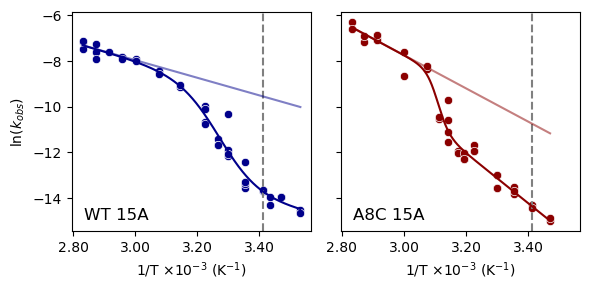

In [11]:
# filter disp_name "4U_wt"
site = 15

# perform fits
fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y = fit_melting_curve(fits, '4U_wt', site)
fits_filt2, melt_result2, smooth_x2, smooth_y2, lnkobs_20C2, lnkobs_20C_err2, lnkadd2, lnkadd_err2, kadd_curve_x2, kadd_curve_y2 = fit_melting_curve(fits, '4U_a8c', site)

# plot log_kappa vs 1/T (axs[0]) and log_kobs vs 1/T (axs[1])
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex = True, sharey = True)
formatter = FuncFormatter(thousands)
color_dict = {'4U_wt': 'darkblue', '4U_a8c': 'darkred'}
# vertical line at 20C
axs[0].axvline(1/(273.15 + 20), color='gray', linestyle='--')
axs[1].axvline(1/(273.15 + 20), color='gray', linestyle='--')

# plot 4U_wt
sns.scatterplot(data=fits_filt, x='inv_temp', y='log_kobs', color=color_dict['4U_wt'], ax=axs[0])
axs[0].plot(smooth_x, smooth_y, color=color_dict['4U_wt'])
axs[0].plot(kadd_curve_x, kadd_curve_y, color=color_dict['4U_wt'], alpha = 0.5)
axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_ylabel(r'$\ln(k_{obs})$')
axs[0].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[0].annotate(f'WT 15A', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)
# plot 4U_a8c
sns.scatterplot(data=fits_filt2, x='inv_temp', y='log_kobs', color=color_dict['4U_a8c'], ax=axs[1])
axs[1].plot(smooth_x2, smooth_y2, color=color_dict['4U_a8c'])
axs[1].plot(kadd_curve_x2, kadd_curve_y2, color=color_dict['4U_a8c'], alpha = 0.5)
axs[1].xaxis.set_major_formatter(formatter)
axs[1].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[1].annotate(f'A8C 15A', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)

plt.tight_layout()
plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/ind_kadd_fit.pdf')
plt.show()

### Plot ln(kobs) without melt curve (18A)

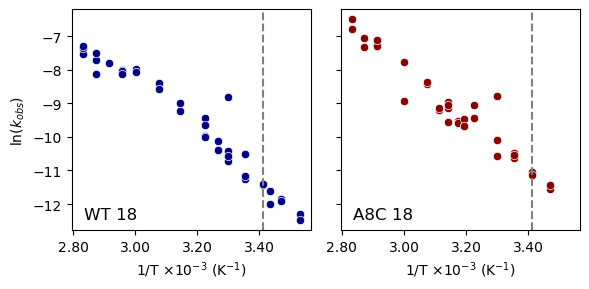

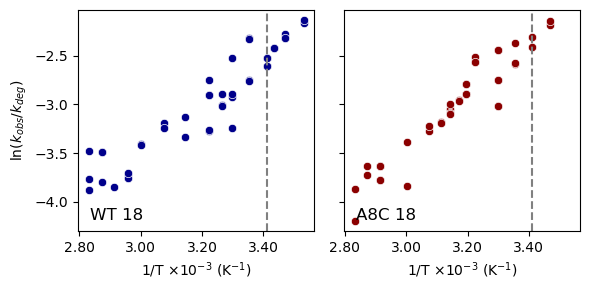

In [13]:
site = 18
fits_filt = fits[(fits['disp_name'] == '4U_wt') & (fits['site'] == site)].copy()
fits_filt.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt['temperature'])
fits_filt.loc[:, 'log_kobs'] = fits_filt['log_kappa'] + fits_filt['log_kdeg']

fits_filt2 = fits[(fits['disp_name'] == '4U_a8c') & (fits['site'] == site)].copy()
fits_filt2.loc[:, 'inv_temp'] = 1/(273.15 + fits_filt2['temperature'])
fits_filt2.loc[:, 'log_kobs'] = fits_filt2['log_kappa'] + fits_filt2['log_kdeg']


# [PLOT] ln_kobs vs 1/T
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex = True, sharey = True)
formatter = FuncFormatter(thousands)
color_dict = {'4U_wt': 'darkblue', '4U_a8c': 'darkred'}

# draw vertical line at 20C
axs[0].axvline(1/(273.15 + 20), color='gray', linestyle='--')
axs[1].axvline(1/(273.15 + 20), color='gray', linestyle='--')

sns.scatterplot(data=fits_filt, x='inv_temp', y='log_kobs', color=color_dict['4U_wt'], ax=axs[0])
axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_ylabel(r'$\ln(k_{obs})$')
axs[0].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[0].annotate(f'WT {site}', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)

sns.scatterplot(data=fits_filt2, x='inv_temp', y='log_kobs', color=color_dict['4U_a8c'], ax=axs[1])
axs[1].xaxis.set_major_formatter(formatter)
axs[1].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[1].annotate(f'A8C {site}', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)

plt.tight_layout()
plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/18A_lnkobs_nofit.pdf')
plt.show()


# [PLOT] ln_kappa vs 1/T
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex = True, sharey = True)
formatter = FuncFormatter(thousands)
color_dict = {'4U_wt': 'darkblue', '4U_a8c': 'darkred'}

# draw vertical line at 20C
axs[0].axvline(1/(273.15 + 20), color='gray', linestyle='--')
axs[1].axvline(1/(273.15 + 20), color='gray', linestyle='--')

sns.scatterplot(data=fits_filt, x='inv_temp', y='log_kappa', color=color_dict['4U_wt'], ax=axs[0])
axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_ylabel(r'$\ln(k_{obs} / k_{deg})$')
axs[0].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[0].annotate(f'WT {site}', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)

sns.scatterplot(data=fits_filt2, x='inv_temp', y='log_kappa', color=color_dict['4U_a8c'], ax=axs[1])
axs[1].xaxis.set_major_formatter(formatter)
axs[1].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[1].annotate(f'A8C {site}', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)

plt.tight_layout()
plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/18A_lnkobs-kdeg-ratio_nofit.pdf')
plt.show()

### Plot ln(kobs) with linear fit (18A)

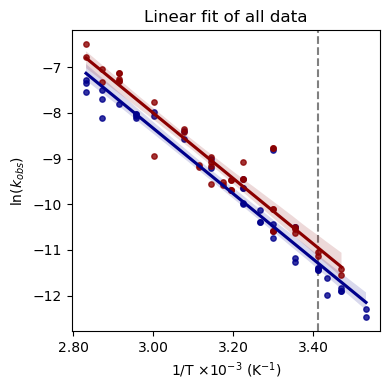

In [14]:
fig, ax = plt.subplots(figsize=(4, 4))
formatter = FuncFormatter(thousands)
color_dict = {'4U_wt': 'darkblue', '4U_a8c': 'darkred'}

sns.regplot(data=fits_filt, x='inv_temp', y='log_kobs', color=color_dict['4U_wt'], scatter_kws={'s': 15})
sns.regplot(data=fits_filt2, x='inv_temp', y='log_kobs', color=color_dict['4U_a8c'], scatter_kws={'s': 15})
ax.axvline(1/(273.15 + 20), color='gray', linestyle='--', zorder = 0)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel(r'$\ln(k_{obs})$')
ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
ax.set_title(f'Linear fit of all data')
plt.tight_layout()
plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/18A_all_linearkobs_fit.pdf')
plt.show()

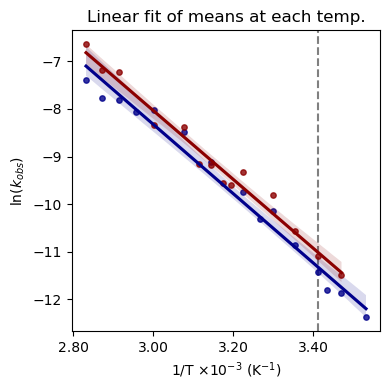

In [15]:
# get average at each 'inv_temp' and plot
avg_kobs = fits_filt.groupby('inv_temp')['log_kobs'].mean().reset_index()
avg_kobs2 = fits_filt2.groupby('inv_temp')['log_kobs'].mean().reset_index()

fig, ax = plt.subplots(figsize=(4, 4))
formatter = FuncFormatter(thousands)
color_dict = {'4U_wt': 'darkblue', '4U_a8c': 'darkred'}

sns.regplot(data=avg_kobs, x='inv_temp', y='log_kobs', color=color_dict['4U_wt'], scatter_kws={'s': 15})
sns.regplot(data=avg_kobs2, x='inv_temp', y='log_kobs', color=color_dict['4U_a8c'], scatter_kws={'s': 15})
ax.axvline(1/(273.15 + 20), color='gray', linestyle='--', zorder = 0)
ax.xaxis.set_major_formatter(formatter)
ax.set_ylabel(r'$\ln(k_{obs})$')
ax.set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
ax.set_title(f'Linear fit of means at each temp.')
plt.tight_layout()
plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/18A_means_linearkobs_fit.pdf')
plt.show()

### ln(kobs) distribution by base

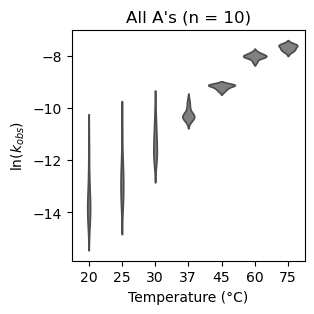

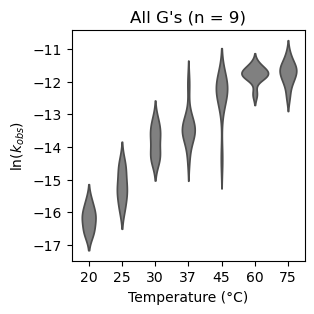

In [16]:
all_melted = fits.copy()#[fits['temperature'] > 59]
# filt name contains "4U_wt" or "4U_a8c"
all_melted = all_melted[all_melted['disp_name'].str.contains('4U_wt')]
# filter temps 25, 30, 37, 45, 52, 60, 75
all_melted = all_melted[all_melted['temperature'].isin([20, 25, 30, 37, 45, 60, 75])]
all_melted.loc[:, 'inv_temp'] = 1/(273.15 + all_melted['temperature'])
all_melted.loc[:, 'log_kobs'] = all_melted['log_kappa'] + all_melted['log_kdeg']

# filter sites 7, 8, 9, 15, 16, 18, 22, 25, 26, 29, 34, 35
all_melted_A = all_melted[all_melted['site'].isin([7, 15, 16, 18, 22, 26, 29, 34, 35])]
all_melted_G = all_melted[all_melted['site'].isin([6, 14, 19, 21, 27, 28, 30, 31, 61, 62])]

# get average at each 'inv_temp' and 'site'
avg_kobs_A = all_melted_A.groupby(['inv_temp', 'temperature', 'site', 'disp_name'])['log_kobs'].mean().reset_index()
avg_kobs_G = all_melted_G.groupby(['inv_temp', 'temperature', 'site', 'disp_name'])['log_kobs'].mean().reset_index()

avg_kobs_A['base'] = 'A'
avg_kobs_G['base'] = 'G'

fig, ax = plt.subplots(figsize=(3, 3))
sns.violinplot(x='temperature', y='log_kobs', data=avg_kobs_A, inner = None, color = 'gray', ax = ax)
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel(r'$\ln(k_{obs})$')
ax.set_title('All A\'s (n = 10)')
# move legend outside of plot
plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/avg_kobs_violin_As.pdf')
plt.show()


fig, ax = plt.subplots(figsize=(3, 3))
sns.violinplot(x='temperature', y='log_kobs', data=avg_kobs_G, inner = None, color = 'gray', ax = ax)
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel(r'$\ln(k_{obs})$')
ax.set_title('All G\'s (n = 9)')
# move legend outside of plot
plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/avg_kobs_violin_Gs.pdf')
plt.show()

            intercept        slope  intercept_se     slope_se
4U_a8c      15.301103 -7753.210853      7.307395  2535.607889
4U_wt        4.057575 -4033.404326      1.663782   565.175331
aggregated  10.338101 -6136.742559      4.076775  1391.452244


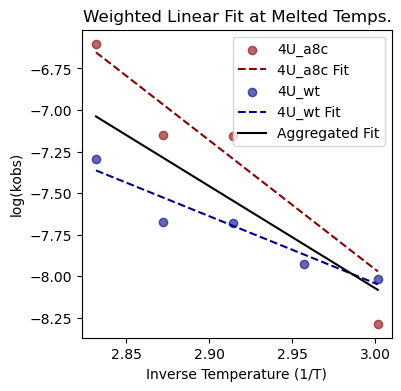

In [18]:
all_melted = fits.copy()#[fits['temperature'] > 59]
# filt name contains "4U_wt" or "4U_a8c"
all_melted = all_melted[all_melted['disp_name'].str.contains('4U_')]
all_melted = all_melted[all_melted['temperature'] > 59]
all_melted.loc[:, 'inv_temp'] = 1/(273.15 + all_melted['temperature'])
all_melted.loc[:, 'log_kobs'] = all_melted['log_kappa'] + all_melted['log_kdeg']

# filter sites 7, 8, 9, 15, 16, 18, 22, 25, 26, 29, 34, 35
all_melted_A = all_melted[all_melted['site'].isin([7, 15, 16, 18, 22, 26, 29, 34, 35])]

# Compute mean and standard deviation of log_kobs at each inv_temp for weighting
grouped = all_melted_A.groupby(['disp_name', 'inv_temp'])['log_kobs'].agg(['mean', 'std']).reset_index()
grouped['weight'] = 1 / (grouped['std'] ** 2)  # Inverse variance weighting

# Function to perform weighted linear regression
def weighted_linear_regression(data):
    X = data['inv_temp'].values
    y = data['mean'].values
    weights = data['weight'].fillna(data['weight'].median()).values  # Handle NaNs in weights

    X = sm.add_constant(X)  # Add intercept
    model = sm.WLS(y, X, weights=weights).fit()

    return model.params, model.bse, model

# Perform regression for each disp_name
results = {}
models = {}

for disp_name, group in grouped.groupby('disp_name'):
    params, errors, model = weighted_linear_regression(group)
    models[disp_name] = model  # Store model for plotting
    results[disp_name] = {
        'intercept': params[0],
        'slope': params[1],
        'intercept_se': errors[0],
        'slope_se': errors[1]
    }

# Perform regression for the aggregated dataset
params, errors, model = weighted_linear_regression(grouped)
models['aggregated'] = model
results['aggregated'] = {
    'intercept': params[0],
    'slope': params[1],
    'intercept_se': errors[0],
    'slope_se': errors[1]
}

# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')

# Print regression results
print(results_df)

# Plot regression results
plt.figure(figsize=(4, 4))
color_dict = {'4U_wt': 'darkblue', '4U_a8c': 'darkred'}

for disp_name, group in grouped.groupby('disp_name'):
    plt.scatter(group['inv_temp'], group['mean'], label=disp_name, alpha=0.6, color = color_dict[disp_name])
    X_fit = np.linspace(group['inv_temp'].min(), group['inv_temp'].max(), 100)
    Y_fit = models[disp_name].params[0] + models[disp_name].params[1] * X_fit
    plt.plot(X_fit, Y_fit, label=f"{disp_name} Fit", linestyle="--", color = color_dict[disp_name])

X_fit = np.linspace(grouped['inv_temp'].min(), grouped['inv_temp'].max(), 100)
Y_fit = models['aggregated'].params[0] + models['aggregated'].params[1] * X_fit

# figsize 4, 4
plt.plot(X_fit, Y_fit, label="Aggregated Fit", linestyle="-", color="black")
# formatter
formatter = FuncFormatter(thousands)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xlabel("Inverse Temperature (1/T)")
plt.ylabel("log(kobs)")
plt.legend()
plt.title("Weighted Linear Fit at Melted Temps.")
#plt.savefig()
plt.show()

agg_kadd_slope = results_df.loc['aggregated', 'slope']
agg_kadd_intercept = results_df.loc['aggregated', 'intercept']

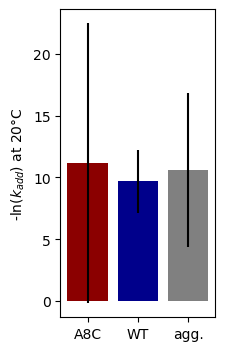

In [19]:
# calculate lnkadd at 20C for each of the regressions
results_df['lnkadd_20C'] = results_df.apply(lambda x: eval_extrapolate(1/(273.15 + 20), x['slope'], x['slope_se'], x['intercept'], x['intercept_se'])[0], axis=1)
results_df['lnkadd_20C_err'] = results_df.apply(lambda x: eval_extrapolate(1/(273.15 + 20), x['slope'], x['slope_se'], x['intercept'], x['intercept_se'])[1], axis=1)

# change index to 'A8C', 'WT', and 'agg.'
results_df.index = ['A8C', 'WT', 'agg.']

# bar plot of lnkadd_20C and err
plt.figure(figsize=(2, 4))
plt.bar(results_df.index, - results_df['lnkadd_20C'], yerr=results_df['lnkadd_20C_err'], color=['darkred', 'darkblue', 'gray'])
plt.ylabel(r'-ln($k_{add}$) at 20°C')
plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/lnkadd_20C_extrapolated.pdf')
plt.show()

### Plot locked kadd (aggregate) site 15A

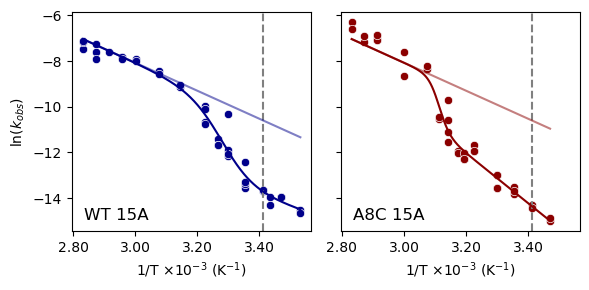

In [20]:
site = 15

# perform fits
kadd_params = (agg_kadd_slope, agg_kadd_intercept)
fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y = fit_melting_curve(fits, '4U_wt', site, kadd_params)
fits_filt2, melt_result2, smooth_x2, smooth_y2, lnkobs_20C2, lnkobs_20C_err2, lnkadd2, lnkadd_err2, kadd_curve_x2, kadd_curve_y2 = fit_melting_curve(fits, '4U_a8c', site, kadd_params)

# plot log_kappa vs 1/T (axs[0]) and log_kobs vs 1/T (axs[1])
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex = True, sharey = True)
formatter = FuncFormatter(thousands)
color_dict = {'4U_wt': 'darkblue', '4U_a8c': 'darkred'}
# vertical line at 20C
axs[0].axvline(1/(273.15 + 20), color='gray', linestyle='--')
axs[1].axvline(1/(273.15 + 20), color='gray', linestyle='--')

# plot 4U_wt
sns.scatterplot(data=fits_filt, x='inv_temp', y='log_kobs', color=color_dict['4U_wt'], ax=axs[0])
axs[0].plot(smooth_x, smooth_y, color=color_dict['4U_wt'])
axs[0].plot(kadd_curve_x, kadd_curve_y, color=color_dict['4U_wt'], alpha = 0.5)
axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_ylabel(r'$\ln(k_{obs})$')
axs[0].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[0].annotate(f'WT 15A', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)
# plot 4U_a8c
sns.scatterplot(data=fits_filt2, x='inv_temp', y='log_kobs', color=color_dict['4U_a8c'], ax=axs[1])
axs[1].plot(smooth_x2, smooth_y2, color=color_dict['4U_a8c'])
axs[1].plot(kadd_curve_x2, kadd_curve_y2, color=color_dict['4U_a8c'], alpha = 0.5)
axs[1].xaxis.set_major_formatter(formatter)
axs[1].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[1].annotate(f'A8C 15A', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)

plt.tight_layout()
plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/locked_kadd_fit.pdf')
plt.show()

### Plotting for G positions

            intercept        slope  intercept_se     slope_se
4U_a8c       4.310064 -5158.200882      3.361099  1160.390860
4U_wt        3.788419 -5195.137326      1.621975   543.701392
aggregated  16.694893 -9456.579194      2.331749   798.972004


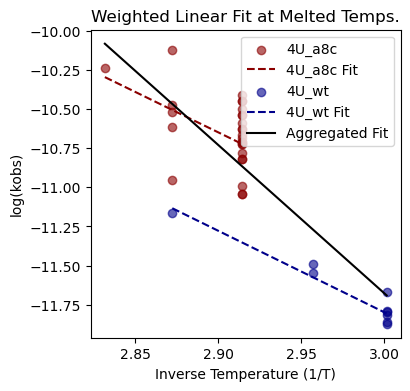

In [21]:
all_melted = fits.copy()#[fits['temperature'] > 59]
# filt name contains "4U_wt" or "4U_a8c"
all_melted = all_melted[all_melted['disp_name'].str.contains('4U_')]
all_melted = all_melted[all_melted['temperature'] > 59]
all_melted.loc[:, 'inv_temp'] = 1/(273.15 + all_melted['temperature'])
all_melted.loc[:, 'log_kobs'] = all_melted['log_kappa'] + all_melted['log_kdeg']

# filter sites 7, 8, 9, 15, 16, 18, 22, 25, 26, 29, 34, 35
all_melted_G = all_melted[all_melted['site'].isin([19, 21, 27, 28, 30, 31, 61, 62])]
# filter r2 above 0.8
all_melted_G = all_melted_G[all_melted_G['r2'] > 0.9]
all_melted_G['weight'] = 1 / (all_melted_G['stderr_log_kappa'] ** 2)  # Inverse variance weighting
grouped = all_melted_G.copy()

# Function to perform weighted linear regression
def weighted_linear_regression(data):
    X = data['inv_temp'].values
    y = data['log_kobs'].values
    weights = data['weight'].fillna(data['weight'].median()).values  # Handle NaNs in weights

    X = sm.add_constant(X)  # Add intercept
    model = sm.WLS(y, X, weights=weights).fit()

    return model.params, model.bse, model

# Perform regression for each disp_name
results = {}
models = {}

for disp_name, group in grouped.groupby('disp_name'):
    params, errors, model = weighted_linear_regression(group)
    models[disp_name] = model  # Store model for plotting
    results[disp_name] = {
        'intercept': params[0],
        'slope': params[1],
        'intercept_se': errors[0],
        'slope_se': errors[1]
    }

# Perform regression for the aggregated dataset
params, errors, model = weighted_linear_regression(grouped)
models['aggregated'] = model
results['aggregated'] = {
    'intercept': params[0],
    'slope': params[1],
    'intercept_se': errors[0],
    'slope_se': errors[1]
}

# Convert results to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index')

# Print regression results
print(results_df)

# Plot regression results
plt.figure(figsize=(4, 4))
color_dict = {'4U_wt': 'darkblue', '4U_a8c': 'darkred'}

for disp_name, group in grouped.groupby('disp_name'):
    plt.scatter(group['inv_temp'], group['log_kobs'], label=disp_name, alpha=0.6, color = color_dict[disp_name])
    X_fit = np.linspace(group['inv_temp'].min(), group['inv_temp'].max(), 100)
    Y_fit = models[disp_name].params[0] + models[disp_name].params[1] * X_fit
    plt.plot(X_fit, Y_fit, label=f"{disp_name} Fit", linestyle="--", color = color_dict[disp_name])

X_fit = np.linspace(grouped['inv_temp'].min(), grouped['inv_temp'].max(), 100)
Y_fit = models['aggregated'].params[0] + models['aggregated'].params[1] * X_fit

# figsize 4, 4
plt.plot(X_fit, Y_fit, label="Aggregated Fit", linestyle="-", color="black")
# formatter
formatter = FuncFormatter(thousands)
plt.gca().xaxis.set_major_formatter(formatter)
plt.xlabel("Inverse Temperature (1/T)")
plt.ylabel("log(kobs)")
plt.legend()
plt.title("Weighted Linear Fit at Melted Temps.")
plt.show()

agg_kadd_slope_Gs = results_df.loc['aggregated', 'slope']
agg_kadd_intercept_Gs = results_df.loc['aggregated', 'intercept']

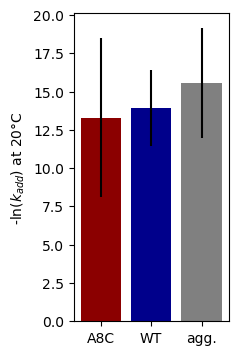

In [22]:
# calculate lnkadd at 20C for each of the regressions
results_df['lnkadd_20C'] = results_df.apply(lambda x: eval_extrapolate(1/(273.15 + 20), x['slope'], x['slope_se'], x['intercept'], x['intercept_se'])[0], axis=1)
results_df['lnkadd_20C_err'] = results_df.apply(lambda x: eval_extrapolate(1/(273.15 + 20), x['slope'], x['slope_se'], x['intercept'], x['intercept_se'])[1], axis=1)

# change index to 'A8C', 'WT', and 'agg.'
results_df.index = ['A8C', 'WT', 'agg.']

# bar plot of lnkadd_20C and err
plt.figure(figsize=(2, 4))
plt.bar(results_df.index, - results_df['lnkadd_20C'], yerr=results_df['lnkadd_20C_err'], color=['darkred', 'darkblue', 'gray'])
plt.ylabel(r'-ln($k_{add}$) at 20°C')
plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/lnkaddGs_20C_extrapolated.pdf')
plt.show()

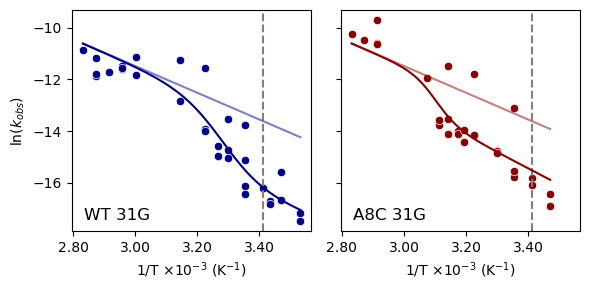

In [24]:
site = 31

agg_kadd_slope_Gs = results_df.loc[['A8C', 'WT'], 'slope'].mean()
agg_kadd_intercept_Gs = results_df.loc[['A8C', 'WT'], 'intercept'].mean()

# perform fits
kadd_params = (agg_kadd_slope_Gs, agg_kadd_intercept_Gs)
fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y = fit_melting_curve(fits, '4U_wt', site, kadd_params)
fits_filt2, melt_result2, smooth_x2, smooth_y2, lnkobs_20C2, lnkobs_20C_err2, lnkadd2, lnkadd_err2, kadd_curve_x2, kadd_curve_y2 = fit_melting_curve(fits, '4U_a8c', site, kadd_params)

# plot log_kappa vs 1/T (axs[0]) and log_kobs vs 1/T (axs[1])
fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex = True, sharey = True)
formatter = FuncFormatter(thousands)
color_dict = {'4U_wt': 'darkblue', '4U_a8c': 'darkred'}
# vertical line at 20C
axs[0].axvline(1/(273.15 + 20), color='gray', linestyle='--')
axs[1].axvline(1/(273.15 + 20), color='gray', linestyle='--')

# plot 4U_wt
sns.scatterplot(data=fits_filt, x='inv_temp', y='log_kobs', color=color_dict['4U_wt'], ax=axs[0])
axs[0].plot(smooth_x, smooth_y, color=color_dict['4U_wt'])
axs[0].plot(kadd_curve_x, kadd_curve_y, color=color_dict['4U_wt'], alpha = 0.5)
axs[0].xaxis.set_major_formatter(formatter)
axs[0].set_ylabel(r'$\ln(k_{obs})$')
axs[0].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[0].annotate(f'WT 31G', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)
# plot 4U_a8c
sns.scatterplot(data=fits_filt2, x='inv_temp', y='log_kobs', color=color_dict['4U_a8c'], ax=axs[1])
axs[1].plot(smooth_x2, smooth_y2, color=color_dict['4U_a8c'])
axs[1].plot(kadd_curve_x2, kadd_curve_y2, color=color_dict['4U_a8c'], alpha = 0.5)
axs[1].xaxis.set_major_formatter(formatter)
axs[1].set_xlabel(r'1/T $\times 10^{-3}$ (K$^{-1}$)')
axs[1].annotate(f'A8C 31G', xy=(0.05, 0.05), xycoords='axes fraction', fontsize = 12)

plt.tight_layout()
plt.savefig('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/locked_kadd_fit_31G.pdf')
plt.show()

### Run fits for all A positions and save to db

In [123]:
def inverse_calc_KKp1(y, top_m, bottom_m, top_b, bottom_b):
    denominator = bottom_m - top_m
    if denominator == 0:
        raise ValueError("Denominator (bottom_m - top_m) is zero; inverse is undefined.")
    
    return (y - (bottom_b - top_b)) / denominator

store_results = []
kadd_params = (agg_kadd_slope, agg_kadd_intercept)
for construct in ['4U_wt', '4U_a8c']:
    for site in [7, 15, 16, 18, 22, 26, 29, 34, 35]:
        try:
            fits_filt, melt_result, smooth_x, smooth_y, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, kadd_curve_x, kadd_curve_y = fit_melting_curve(fits, construct, site)
        except:
            continue    
        # fit quality
        r2 = melt_result.rsquared

        # calculate dG at 20C (kcal/mol)
        KKp1 = np.exp(lnkobs_20C - lnkadd)
        Kval = KKp1 / (1 - KKp1)
        Kval_err = KKp1 * lnkobs_20C_err
        dG = -1.987 * 293.15 * np.log(Kval) * 10**(-3)
        dG_err = abs(-1.987 * 293.15 * Kval_err * 10**(-3))

        # store global tm
        tm = melt_result.params['g'].value
        tm_err = melt_result.params['g'].stderr

        # store global dH
        dH = melt_result.params['f'].value
        dH_err = melt_result.params['f'].stderr

        # calculate local tm
        # top_m = melt_result.params['a'].value
        # top_b = melt_result.params['b'].value
        # bottom_m = melt_result.params['c'].value
        # bottom_b = melt_result.params['d'].value
        # local_tm = (1 / inverse_calc_KKp1(np.log(0.5), top_m, bottom_m, top_b, bottom_b)) - 273.15
        
        store_results.append([construct, site, r2, tm, tm_err, dH, dH_err, lnkobs_20C, lnkobs_20C_err, lnkadd, lnkadd_err, dG, dG_err])

# to dataframe
store_results = pd.DataFrame(store_results, columns=['construct', 'site', 'r2', 'tm', 'tm_err', 'dH', 'dH_err', 'lnkobs_20C', 'lnkobs_20C_err', 'lnkadd', 'lnkadd_err', 'dG', 'dG_err'])
store_results.to_csv('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/fit_results.csv', index=False)

/tmp/ipykernel_193678/1769102294.py:17: RuntimeWarning: overflow encountered in exp
  K1 = np.exp((f/R)*(1/(g+273.15) - 1/(temp)))
/tmp/ipykernel_193678/1769102294.py:20: RuntimeWarning: invalid value encountered in divide
  fracf = K1 / Q1
/tmp/ipykernel_193678/1769102294.py:24: RuntimeWarning: divide by zero encountered in log
  final = np.log(fracu) * baseu + np.log(fracf) * basef
/tmp/ipykernel_193678/1769102294.py:24: RuntimeWarning: divide by zero encountered in log
  final = np.log(fracu) * baseu + np.log(fracf) * basef
/tmp/ipykernel_193678/1769102294.py:17: RuntimeWarning: overflow encountered in exp
  K1 = np.exp((f/R)*(1/(g+273.15) - 1/(temp)))
/tmp/ipykernel_193678/1769102294.py:20: RuntimeWarning: invalid value encountered in scalar divide
  fracf = K1 / Q1


In [124]:
locked_kadd = pd.read_csv('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/fit_results_lockedkadd.csv')
ind_kadd = pd.read_csv('/projects/b1044/Computational_Output/EKC/EKC.01_SHAPE_standardization/EKC.01.061.analyze_fit_distributions/new_global_analysis_plots/fit_results.csv')

In [125]:
ind_kadd

,construct,site,r2,tm,tm_err,dH,dH_err,lnkobs_20C,lnkobs_20C_err,lnkadd,lnkadd_err,dG,dG_err
0,4U_wt,7,0.977480,26.399312,1.030758e+01,-103.119499,5.888176e+01,-12.599367,0.112079,-9.801732,9.542773e+00,1.592959,3.979375e-03
1,4U_wt,15,0.981183,32.344542,3.874392e+00,-121.568526,4.813415e+01,-13.702584,0.129066,-9.409618,9.803391e+00,2.492592,1.027276e-03
2,4U_wt,16,0.981492,33.557338,3.937804e+00,-122.336645,5.058411e+01,-13.992710,0.130944,-9.469044,1.016860e+01,2.628632,8.275025e-04
3,4U_wt,18,0.959987,38.545727,8.653941e+01,-57.848569,1.754900e+02,-11.402262,40.552929,-8.902194,6.210634e+01,1.406375,1.938851e+00
4,4U_wt,22,0.977546,35.236967,4.202920e+00,-120.580593,5.915488e+01,-13.163080,0.128350,-9.278568,1.149437e+01,2.250586,1.536957e-03
5,4U_wt,26,0.982625,32.601949,3.926066e+00,-124.886129,4.909506e+01,-14.242811,0.137055,-9.498556,9.707583e+00,2.758386,6.946709e-04
6,4U_wt,29,0.984278,33.858357,2.109202e+00,-178.392456,6.151041e+01,-14.284441,0.131443,-10.169884,6.118024e+00,2.387092,1.250531e-03
7,4U_wt,34,0.966641,24.230207,5.696278e+00,-154.258724,7.574101e+01,-13.793911,0.180496,-10.907418,6.973110e+00,1.647923,5.863654e-03
8,4U_wt,35,0.973530,16.940304,3.426768e+01,-75.129966,5.410979e+01,-13.550248,0.141198,-9.343003,2.130417e+01,2.441937,1.224428e-03
9,4U_a8c,7,0.976095,47.255802,1.707152e+00,-333.346974,1.711218e+02,-14.214097,0.168037,-10.950990,1.135002e+01,1.877995,3.745794e-03


Text(0.5, 1.0, 'Locked $k_{add}$')

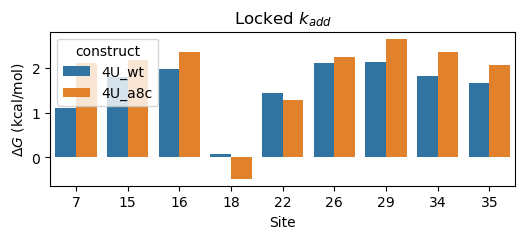

In [ ]:
# barplot locked kadd with error bars
plt.figure(figsize=(6, 2))
sns.barplot(data=locked_kadd, x='site', y='dG', hue='construct', color)
plt.ylabel(r'$\Delta G$ (kcal/mol)')
plt.xlabel('Site')
plt.title('Locked $k_{add}$')
